In [98]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import os

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches
# Some modules to display an animation using imageio.
import imageio
print(tf.config.list_physical_devices('GPU'))

import sys
sys.path.insert(1, '..')
from GRU import BIGRU
import pytorch_utils

import torch
torch.zeros(1).cuda()

[]


tensor([0.], device='cuda:0')

In [99]:
#@title Helper functions for visualization

# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'black',
    (7, 9): 'black',
    (6, 8): 'white',
    (8, 10): 'white',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors

def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None, threshold=.11):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width, keypoint_threshold=threshold)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot


In [100]:
model_name = "movenet_thunder" #@param ["movenet_lightning", "movenet_thunder", "movenet_lightning_f16.tflite", "movenet_thunder_f16.tflite", "movenet_lightning_int8.tflite", "movenet_thunder_int8.tflite"]

def movenet(input_image):
    """Runs detection on an input image.

    Args:
    input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
    A [1, 1, 17, 3] float numpy array representing the predicted keypoint
    coordinates and scores.
    """

    if "movenet_lightning" in model_name:
        module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
        input_size = 192
    elif "movenet_thunder" in model_name:
        module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
        input_size = 256
    else:
        raise ValueError("Unsupported model name: %s" % model_name)

    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

In [101]:
def process(path):
    # Load the input image.
    image_path = os.path.join(dir, path)#'training/16/11783.3.jpg'
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)

    # Resize and pad the image to keep the aspect ratio and fit the expected size.
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

    # Run model inference.
    keypoints_with_scores = movenet(input_image)
    print(keypoints_with_scores)

    # Visualize the predictions with image.
    display_image = tf.expand_dims(image, axis=0)
    display_image = tf.cast(tf.image.resize_with_pad(
        display_image, 1280, 1280), dtype=tf.int32)
    output_overlay = draw_prediction_on_image(
        np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores, threshold=0.3)

    plt.figure(figsize=(5, 5))
    plt.imshow(output_overlay)
    _ = plt.axis('off')

# import os
# from ipywidgets import interact
# dir = 'training/17'
# files = os.listdir(dir)
# interact(process, path=files)

In [102]:
def load_imigue():
    import pandas as pd
    # import os

    # df = pd.DataFrame(columns=['path', 'class', 'video_id', 'frame'])
    # for i in range(1, 33):
    #     dir = 'training/' + str(i)
    #     files = os.listdir(dir)
    #     for file in files:
    #         df.loc[len(df.index)] = [os.path.join(str(i), file), i, file.split('.')[0], file.split('.')[1]]
    # return df
    return pd.read_csv('metadata.csv')

df = load_imigue()

In [103]:
def add_pose_data(df):
    for k in KEYPOINT_DICT.keys():
        df[f'{k}_0'] = 0.0
        df[f'{k}_1'] = 0.0
        df[f'{k}_score'] = 0.0

    for i in range(len(df)):
        row = df.iloc[i]
        # Load the input image.
        image_path = os.path.join('training', row.path)
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image)

        # Resize and pad the image to keep the aspect ratio and fit the expected size.
        input_size = 256
        input_image = tf.expand_dims(image, axis=0)
        input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

        # Run model inference.
        keypoints_with_scores = movenet(input_image)
        for k, v in KEYPOINT_DICT.items():
            values = keypoints_with_scores[0][0][v]
            df.iloc[i, df.columns.get_loc(f'{k}_0')] = values[0]
            df.iloc[i, df.columns.get_loc(f'{k}_1')] = values[1]
            df.iloc[i, df.columns.get_loc(f'{k}_score')] = values[2]

df

,Unnamed: 0,path,class,video_id,frame,nose_0,nose_1,nose_score,left_eye_0,left_eye_1,...,left_knee_score,right_knee_0,right_knee_1,right_knee_score,left_ankle_0,left_ankle_1,left_ankle_score,right_ankle_0,right_ankle_1,right_ankle_score
0,41,1/676.2.jpg,1,676,2,0.536940,0.519220,0.176915,0.482901,0.554157,...,0.127321,0.739197,0.322254,0.401741,0.723482,0.439374,0.097672,0.753613,0.624171,0.215106
1,71,1/676.3.jpg,1,676,3,0.527566,0.505588,0.320876,0.486930,0.538982,...,0.112204,0.738475,0.322620,0.354696,0.742008,0.587786,0.084846,0.752234,0.625011,0.210873
2,19,1/676.4.jpg,1,676,4,0.520691,0.523298,0.207465,0.473461,0.559082,...,0.149931,0.735181,0.318123,0.483617,0.738399,0.582698,0.114686,0.751253,0.611784,0.219790
3,90,1/676.5.jpg,1,676,5,0.541147,0.514972,0.211949,0.487922,0.551379,...,0.116105,0.735202,0.317601,0.381059,0.737782,0.582862,0.094748,0.752435,0.624138,0.167352
4,43,1/676.6.jpg,1,676,6,0.508418,0.529349,0.218647,0.461819,0.569866,...,0.145684,0.739282,0.318815,0.468959,0.708210,0.466800,0.120853,0.745579,0.605821,0.268091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60509,56970,32/17699.5.jpg,32,17699,5,0.410697,0.550067,0.300542,0.371683,0.582072,...,0.059571,0.774956,0.343825,0.112110,0.775187,0.539377,0.033483,0.778112,0.508907,0.057826
60510,56615,32/17707.0.jpg,32,17707,0,0.497047,0.554310,0.278072,0.464215,0.599753,...,0.069238,0.768674,0.450558,0.154153,0.779981,0.601488,0.026040,0.771737,0.491129,0.176495
60511,54972,32/17707.1.jpg,32,17707,1,0.456710,0.519351,0.246757,0.391514,0.559125,...,0.090489,0.772732,0.323692,0.090784,0.769023,0.533433,0.116141,0.775654,0.447653,0.127975
60512,54629,32/17707.2.jpg,32,17707,2,0.439786,0.550717,0.238725,0.387315,0.580766,...,0.037351,0.772637,0.379241,0.069503,0.772449,0.558960,0.052951,0.778140,0.529624,0.055858


In [104]:
def make_lstm_input(df):
    df = df[['class', 'video_id', 'nose_0', 'nose_1', 'nose_score',
       'left_eye_0', 'left_eye_1', 'left_eye_score', 'right_eye_0',
       'right_eye_1', 'right_eye_score', 'left_ear_0', 'left_ear_1',
       'left_ear_score', 'right_ear_0', 'right_ear_1', 'right_ear_score',
       'left_shoulder_0', 'left_shoulder_1', 'left_shoulder_score',
       'right_shoulder_0', 'right_shoulder_1', 'right_shoulder_score',
       'left_elbow_0', 'left_elbow_1', 'left_elbow_score', 'right_elbow_0',
       'right_elbow_1', 'right_elbow_score', 'left_wrist_0', 'left_wrist_1',
       'left_wrist_score']]
    df = df.groupby(['class','video_id']).apply(lambda x: x.values.tolist()).tolist()
    seq_target_count = 7
    data_tmp = []
    for i in range(len(df)):
        sequences = df[i]
        data_tmp.append([])
        for j in range(seq_target_count):
            if j < len(sequences):
                data_tmp[i].append(sequences[j])
            else:
                # data_tmp[i].append(sequences[-1])
                data_tmp[i].append([0] * 32)
    data_tmp = np.array(data_tmp)
    data_tmp = data_tmp[:11000]
    return data_tmp[:, :, 2:], data_tmp[:, 0, 0].flatten().astype(int)

# data_x = make_lstm_input(df)
# data[class_video][data_seq_index][32]
data_X, data_Y = make_lstm_input(df)
data_Y = data_Y - 1

In [105]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, test_size=0.33, random_state=42)

In [106]:
# LSTM for sequence classification in the IMDB dataset
# import tensorflow as tf
# from tensorflow.keras.datasets import imdb
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import LSTM, Conv2D, MaxPooling2D
# from tensorflow.keras.layers import Embedding
# from tensorflow.keras.preprocessing import sequence
# fix random seed for reproducibility
# tf.random.set_seed(7)
# create the model
# model = Sequential()
# model.add(LSTM(100, input_shape=(50, 30)))
# model.add(Dense(32, activation='softmax'))
# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())
# model.fit(X_train, y_train, epochs=1, batch_size=64)


In [107]:
device = 'cuda'
model = BIGRU(30, 50, num_class=32, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()
for i in range(10):
    loss = pytorch_utils.train_one_epoch(i, model, pytorch_utils.make_dataset(X_train, y_train, batch_size=64), optimizer, loss_fn, device=device)
# torch.save(model, 'bigru.pth')

  batch 1 loss: 3.4851810932159424
  batch 2 loss: 3.4366769790649414
  batch 3 loss: 3.3808281421661377
  batch 4 loss: 3.337273120880127
  batch 5 loss: 3.2922539710998535
  batch 6 loss: 3.286862373352051
  batch 7 loss: 3.1937873363494873
  batch 8 loss: 3.077843427658081
  batch 9 loss: 3.0385890007019043
  batch 10 loss: 3.00408673286438
  batch 11 loss: 3.0159494876861572
  batch 12 loss: 2.999701499938965
  batch 13 loss: 2.7429139614105225
  batch 14 loss: 2.7997617721557617
  batch 15 loss: 3.0101804733276367
  batch 16 loss: 2.723828077316284
  batch 17 loss: 2.475606918334961
  batch 18 loss: 2.774893045425415
  batch 19 loss: 2.718452215194702
  batch 20 loss: 2.502481460571289
  batch 21 loss: 2.6398355960845947
  batch 22 loss: 2.7291083335876465
  batch 23 loss: 2.6569719314575195
  batch 24 loss: 2.812772035598755
  batch 25 loss: 2.994558095932007
  batch 26 loss: 2.825977087020874
  batch 27 loss: 2.793628692626953
  batch 28 loss: 2.3324475288391113
  batch 29 loss:

In [108]:
with torch.no_grad():
    model.eval()
    output = model(torch.Tensor(X_test).to(device))
    maxk = 1
    _, y_pred = output.topk(maxk, 1, True, True)
    y_pred = y_pred.t()[0].cpu().numpy()

# y_pred = model(X_test)
# y_pred = np.argmax(y_pred, axis=1)

In [109]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00       138
           2       0.00      0.00      0.00        15
           3       0.72      0.18      0.29        71
           4       0.00      0.00      0.00        28
           5       0.00      0.00      0.00        14
           6       0.00      0.00      0.00        17
           7       0.34      0.49      0.40       223
           8       0.00      0.00      0.00        22
           9       0.00      0.00      0.00         2
          10       0.21      0.33      0.25       101
          11       0.00      0.00      0.00        49
          12       0.00      0.00      0.00        23
          13       0.00      0.00      0.00        17
          14       0.00      0.00      0.00        10
          15       0.00      0.00      0.00        10
          16       0.35      0.47      0.40       101
          17       0.00    

/aleksandr_algasov/env/gestures/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/aleksandr_algasov/env/gestures/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/aleksandr_algasov/env/gestures/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


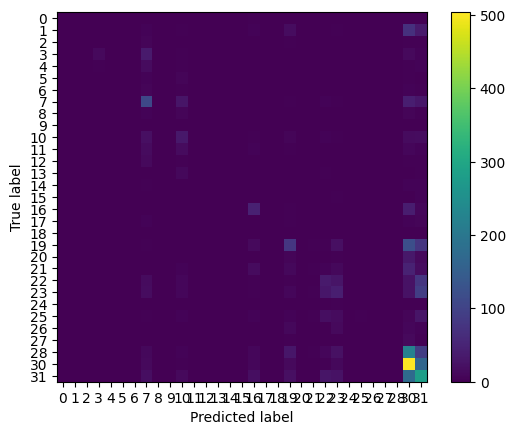

In [110]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, include_values=False)